# **simpleNN**

##**neural network diagram**

<svg xmlns="http://www.w3.org/2000/svg" width="1600" height="765" style="cursor: move;"><g transform="translate(0,0) scale(1)"><path class="link" marker-end="url(#arrow)" d="M480,372.5, 660,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M480,372.5, 660,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M480,372.5, 660,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M480,372.5, 660,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M480,372.5, 660,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M480,372.5, 660,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M480,372.5, 660,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M480,372.5, 660,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M480,372.5, 660,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M480,372.5, 660,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M480,372.5, 660,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,152.5, 840,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,152.5, 840,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,152.5, 840,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,152.5, 840,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,152.5, 840,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,152.5, 840,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,152.5, 840,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,152.5, 840,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,192.5, 840,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,192.5, 840,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,192.5, 840,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,192.5, 840,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,192.5, 840,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,192.5, 840,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,192.5, 840,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,192.5, 840,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,232.5, 840,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,232.5, 840,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,232.5, 840,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,232.5, 840,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,232.5, 840,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,232.5, 840,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,232.5, 840,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,232.5, 840,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,272.5, 840,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,272.5, 840,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,272.5, 840,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,272.5, 840,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,272.5, 840,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,272.5, 840,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,272.5, 840,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,272.5, 840,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,312.5, 840,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,312.5, 840,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,312.5, 840,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,312.5, 840,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,312.5, 840,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,312.5, 840,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,312.5, 840,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,312.5, 840,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,352.5, 840,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,352.5, 840,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,352.5, 840,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,352.5, 840,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,352.5, 840,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,352.5, 840,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,352.5, 840,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,352.5, 840,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,392.5, 840,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,392.5, 840,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,392.5, 840,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,392.5, 840,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,392.5, 840,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,392.5, 840,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,392.5, 840,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,392.5, 840,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,432.5, 840,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,432.5, 840,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,432.5, 840,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,432.5, 840,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,432.5, 840,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,432.5, 840,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,432.5, 840,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,432.5, 840,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,472.5, 840,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,472.5, 840,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,472.5, 840,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,472.5, 840,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,472.5, 840,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,472.5, 840,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,472.5, 840,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,472.5, 840,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,512.5, 840,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,512.5, 840,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,512.5, 840,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,512.5, 840,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,512.5, 840,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,512.5, 840,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,512.5, 840,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,512.5, 840,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,552.5, 840,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,552.5, 840,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,552.5, 840,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,552.5, 840,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,552.5, 840,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,552.5, 840,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,552.5, 840,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,552.5, 840,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,592.5, 840,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,592.5, 840,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,592.5, 840,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,592.5, 840,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,592.5, 840,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,592.5, 840,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,592.5, 840,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,592.5, 840,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,152.5, 840,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,192.5, 840,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,232.5, 840,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,272.5, 840,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,312.5, 840,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,352.5, 840,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,392.5, 840,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,432.5, 840,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,472.5, 840,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,512.5, 840,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,552.5, 840,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,592.5, 840,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,152.5, 840,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,192.5, 840,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,232.5, 840,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,272.5, 840,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,312.5, 840,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,352.5, 840,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,392.5, 840,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,432.5, 840,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,472.5, 840,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,512.5, 840,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,552.5, 840,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,592.5, 840,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,152.5, 840,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,192.5, 840,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,232.5, 840,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,272.5, 840,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,312.5, 840,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,352.5, 840,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,392.5, 840,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,432.5, 840,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,472.5, 840,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,512.5, 840,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,552.5, 840,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,592.5, 840,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,152.5, 1020,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,192.5, 1020,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,232.5, 1020,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,272.5, 1020,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,312.5, 1020,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,352.5, 1020,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,392.5, 1020,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,432.5, 1020,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,472.5, 1020,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,512.5, 1020,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,552.5, 1020,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,592.5, 1020,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,152.5, 1020,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,192.5, 1020,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,232.5, 1020,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,272.5, 1020,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,312.5, 1020,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,352.5, 1020,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,392.5, 1020,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,432.5, 1020,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,472.5, 1020,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,512.5, 1020,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,552.5, 1020,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,592.5, 1020,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,152.5, 1020,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,192.5, 1020,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,232.5, 1020,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,272.5, 1020,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,312.5, 1020,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,352.5, 1020,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,392.5, 1020,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,432.5, 1020,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,472.5, 1020,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,512.5, 1020,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,552.5, 1020,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,592.5, 1020,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,152.5, 1020,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,192.5, 1020,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,232.5, 1020,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,272.5, 1020,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,312.5, 1020,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,352.5, 1020,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,392.5, 1020,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,432.5, 1020,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,472.5, 1020,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,512.5, 1020,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,552.5, 1020,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,592.5, 1020,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,152.5, 1020,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,192.5, 1020,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,232.5, 1020,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,272.5, 1020,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,312.5, 1020,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,352.5, 1020,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,392.5, 1020,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,432.5, 1020,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,472.5, 1020,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,512.5, 1020,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,552.5, 1020,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,592.5, 1020,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,152.5, 1020,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,192.5, 1020,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,232.5, 1020,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,272.5, 1020,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,312.5, 1020,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,352.5, 1020,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,392.5, 1020,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,432.5, 1020,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,472.5, 1020,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,512.5, 1020,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,552.5, 1020,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,592.5, 1020,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,152.5, 1020,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,192.5, 1020,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,232.5, 1020,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,272.5, 1020,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,312.5, 1020,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,352.5, 1020,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,392.5, 1020,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,432.5, 1020,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,472.5, 1020,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,512.5, 1020,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,552.5, 1020,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,592.5, 1020,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,152.5, 1020,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,192.5, 1020,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,232.5, 1020,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,272.5, 1020,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,312.5, 1020,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,352.5, 1020,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,392.5, 1020,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,432.5, 1020,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,472.5, 1020,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,512.5, 1020,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,552.5, 1020,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,592.5, 1020,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,152.5, 1020,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,192.5, 1020,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,232.5, 1020,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,272.5, 1020,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,312.5, 1020,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,352.5, 1020,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,392.5, 1020,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,432.5, 1020,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,472.5, 1020,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,512.5, 1020,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,552.5, 1020,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,592.5, 1020,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,152.5, 1020,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,192.5, 1020,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,232.5, 1020,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,272.5, 1020,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,312.5, 1020,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,352.5, 1020,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,392.5, 1020,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,432.5, 1020,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,472.5, 1020,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,512.5, 1020,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,552.5, 1020,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,592.5, 1020,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,152.5, 1020,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,192.5, 1020,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,232.5, 1020,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,272.5, 1020,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,312.5, 1020,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,352.5, 1020,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,392.5, 1020,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,432.5, 1020,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,472.5, 1020,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,512.5, 1020,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,552.5, 1020,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,592.5, 1020,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,152.5, 1200,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,192.5, 1200,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,232.5, 1200,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,272.5, 1200,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,312.5, 1200,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,352.5, 1200,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,392.5, 1200,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,432.5, 1200,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,472.5, 1200,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,512.5, 1200,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,552.5, 1200,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,592.5, 1200,192.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,152.5, 1200,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,192.5, 1200,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,232.5, 1200,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,272.5, 1200,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,312.5, 1200,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,352.5, 1200,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,392.5, 1200,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,432.5, 1200,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,472.5, 1200,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,512.5, 1200,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,552.5, 1200,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,592.5, 1200,232.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,152.5, 1200,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,192.5, 1200,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,232.5, 1200,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,272.5, 1200,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,312.5, 1200,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,352.5, 1200,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,392.5, 1200,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,432.5, 1200,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,472.5, 1200,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,512.5, 1200,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,552.5, 1200,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,592.5, 1200,272.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,152.5, 1200,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,192.5, 1200,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,232.5, 1200,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,272.5, 1200,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,312.5, 1200,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,352.5, 1200,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,392.5, 1200,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,432.5, 1200,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,472.5, 1200,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,512.5, 1200,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,552.5, 1200,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,592.5, 1200,312.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,152.5, 1200,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,192.5, 1200,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,232.5, 1200,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,272.5, 1200,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,312.5, 1200,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,352.5, 1200,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,392.5, 1200,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,432.5, 1200,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,472.5, 1200,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,512.5, 1200,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,552.5, 1200,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,592.5, 1200,352.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,152.5, 1200,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,192.5, 1200,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,232.5, 1200,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,272.5, 1200,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,312.5, 1200,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,352.5, 1200,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,392.5, 1200,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,432.5, 1200,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,472.5, 1200,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,512.5, 1200,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,552.5, 1200,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,592.5, 1200,392.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,152.5, 1200,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,192.5, 1200,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,232.5, 1200,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,272.5, 1200,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,312.5, 1200,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,352.5, 1200,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,392.5, 1200,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,432.5, 1200,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,472.5, 1200,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,512.5, 1200,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,552.5, 1200,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,592.5, 1200,432.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,152.5, 1200,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,192.5, 1200,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,232.5, 1200,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,272.5, 1200,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,312.5, 1200,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,352.5, 1200,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,392.5, 1200,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,432.5, 1200,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,472.5, 1200,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,512.5, 1200,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,552.5, 1200,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,592.5, 1200,472.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,152.5, 1200,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,192.5, 1200,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,232.5, 1200,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,272.5, 1200,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,312.5, 1200,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,352.5, 1200,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,392.5, 1200,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,432.5, 1200,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,472.5, 1200,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,512.5, 1200,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,552.5, 1200,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,592.5, 1200,512.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,152.5, 1200,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,192.5, 1200,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,232.5, 1200,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,272.5, 1200,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,312.5, 1200,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,352.5, 1200,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,392.5, 1200,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,432.5, 1200,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,472.5, 1200,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,512.5, 1200,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,552.5, 1200,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,592.5, 1200,552.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,152.5, 1200,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,192.5, 1200,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,232.5, 1200,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,272.5, 1200,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,312.5, 1200,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,352.5, 1200,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,392.5, 1200,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,432.5, 1200,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,472.5, 1200,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,512.5, 1200,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,552.5, 1200,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,592.5, 1200,592.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1200,152.5, 1380,372.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1200,192.5, 1380,372.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1200,232.5, 1380,372.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1200,272.5, 1380,372.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1200,312.5, 1380,372.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1200,352.5, 1380,372.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1200,392.5, 1380,372.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1200,432.5, 1380,372.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1200,472.5, 1380,372.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1200,512.5, 1380,372.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1200,552.5, 1380,372.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1200,592.5, 1380,372.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M480,372.5, 660,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,152.5, 840,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,192.5, 840,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,232.5, 840,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,272.5, 840,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,312.5, 840,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,352.5, 840,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,392.5, 840,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,432.5, 840,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,472.5, 840,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,512.5, 840,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,552.5, 840,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M660,592.5, 840,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,152.5, 1020,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,192.5, 1020,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,232.5, 1020,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,272.5, 1020,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,312.5, 1020,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,352.5, 1020,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,392.5, 1020,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,432.5, 1020,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,472.5, 1020,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,512.5, 1020,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,552.5, 1020,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M840,592.5, 1020,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,152.5, 1200,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,192.5, 1200,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,232.5, 1200,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,272.5, 1200,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,312.5, 1200,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,352.5, 1200,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,392.5, 1200,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,432.5, 1200,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,472.5, 1200,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,512.5, 1200,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,552.5, 1200,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><path class="link" marker-end="url(#arrow)" d="M1020,592.5, 1200,152.5" style="stroke-width: 0.5; stroke-opacity: 1; stroke: rgb(80, 80, 80);"></path><circle r="10" class="node" id="0_0" cx="480" cy="372.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="1_0" cx="660" cy="152.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="1_1" cx="660" cy="192.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="1_2" cx="660" cy="232.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="1_3" cx="660" cy="272.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="1_4" cx="660" cy="312.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="1_5" cx="660" cy="352.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="1_6" cx="660" cy="392.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="1_7" cx="660" cy="432.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="1_8" cx="660" cy="472.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="1_9" cx="660" cy="512.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="1_10" cx="660" cy="552.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="1_11" cx="660" cy="592.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="2_0" cx="840" cy="152.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="2_1" cx="840" cy="192.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="2_2" cx="840" cy="232.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="2_3" cx="840" cy="272.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="2_4" cx="840" cy="312.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="2_5" cx="840" cy="352.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="2_6" cx="840" cy="392.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="2_7" cx="840" cy="432.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="2_8" cx="840" cy="472.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="2_9" cx="840" cy="512.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="2_10" cx="840" cy="552.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="2_11" cx="840" cy="592.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="3_0" cx="1020" cy="152.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><text class="text" dy=".35em" x="445" y="632.5" style="font-size: 12px;">Input Layer ∈ ℝ¹</text><text class="text" dy=".35em" x="625" y="632.5" style="font-size: 12px;">Hidden Layer ∈ ℝ¹²</text><text class="text" dy=".35em" x="805" y="632.5" style="font-size: 12px;">Hidden Layer ∈ ℝ¹²</text><text class="text" dy=".35em" x="985" y="632.5" style="font-size: 12px;">Hidden Layer ∈ ℝ¹²</text><circle r="10" class="node" id="3_1" cx="1020" cy="192.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="3_2" cx="1020" cy="232.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="3_3" cx="1020" cy="272.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="3_4" cx="1020" cy="312.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="3_5" cx="1020" cy="352.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="3_6" cx="1020" cy="392.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="3_7" cx="1020" cy="432.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="3_8" cx="1020" cy="472.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="3_9" cx="1020" cy="512.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="3_10" cx="1020" cy="552.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="3_11" cx="1020" cy="592.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="4_0" cx="1200" cy="152.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><text class="text" dy=".35em" x="1165" y="632.5" style="font-size: 12px;">Hidden Layer ∈ ℝ¹²</text><circle r="10" class="node" id="4_1" cx="1200" cy="192.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="4_2" cx="1200" cy="232.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="4_3" cx="1200" cy="272.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="4_4" cx="1200" cy="312.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="4_5" cx="1200" cy="352.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="4_6" cx="1200" cy="392.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="4_7" cx="1200" cy="432.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="4_8" cx="1200" cy="472.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="4_9" cx="1200" cy="512.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="4_10" cx="1200" cy="552.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10"class="node" id="4_11" cx="1200" cy="592.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><circle r="10" class="node" id="5_0" cx="1380" cy="372.5" style="fill: rgb(25, 200, 25); stroke: rgb(25, 200, 25);"></circle><text class="text" dy=".35em" x="1345" y="632.5" style="font-size: 12px;">Output Layer ∈ ℝ¹</text></g><defs><marker id="arrow" viewBox="0 -5 10 10" markerWidth="7" markerHeight="7" orient="auto" refX="40"><path d="M0,-5L10,0L0,5" style="stroke: rgb(80, 80, 80); fill: rgb(80, 80, 80);"></path></marker></defs></svg>

simpleNN.svg

## excutable codes 
(a series of results will show up anytime you make it fire.  )

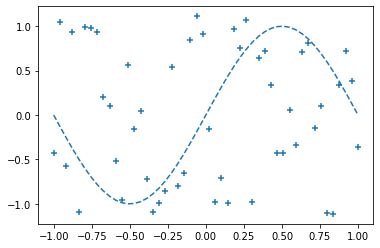

Epoch:0/1001 Error:0.46465847763229945


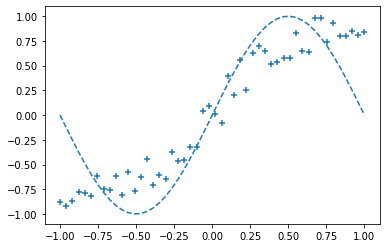

Epoch:50/1001 Error:0.06533143542943404


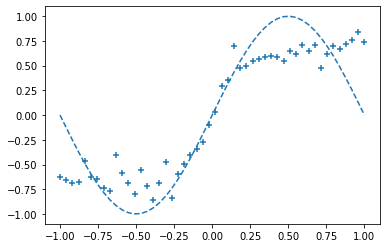

Epoch:100/1001 Error:0.046870016418233525


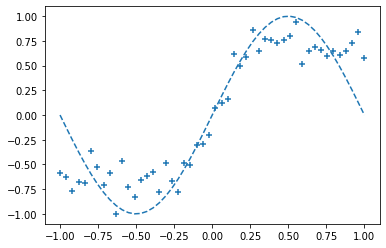

Epoch:150/1001 Error:0.03858672158335035


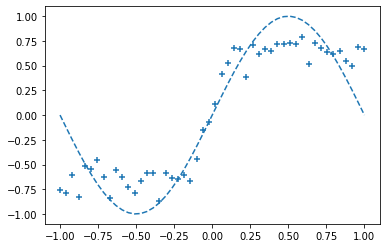

Epoch:200/1001 Error:0.041015779160951116


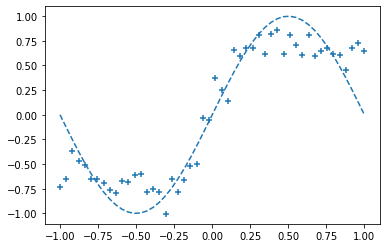

Epoch:250/1001 Error:0.03334331366866437


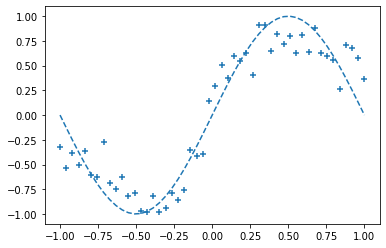

Epoch:300/1001 Error:0.02527377109024713


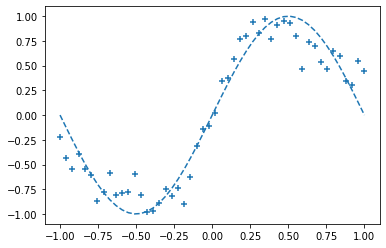

Epoch:350/1001 Error:0.018508387017156035


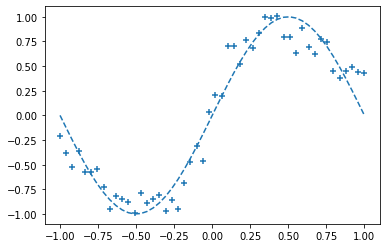

Epoch:400/1001 Error:0.015246375988895841


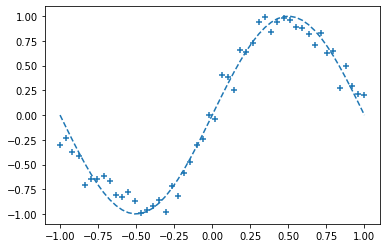

Epoch:450/1001 Error:0.007073883630816826


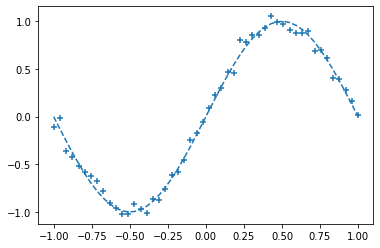

Epoch:500/1001 Error:0.001721164581673833


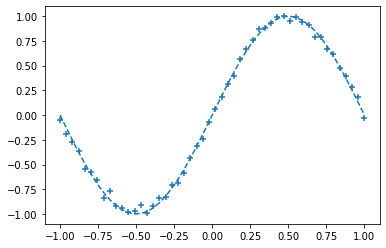

Epoch:550/1001 Error:0.000589538467131742


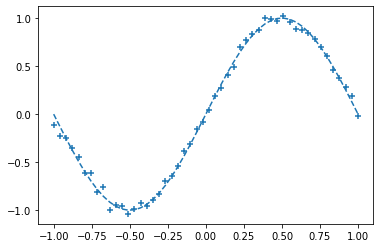

Epoch:600/1001 Error:0.0009039743225999604


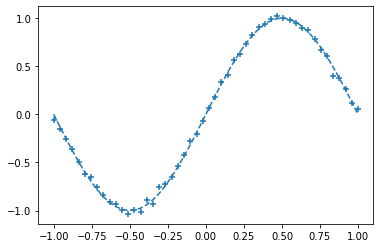

Epoch:650/1001 Error:0.00038882559120645963


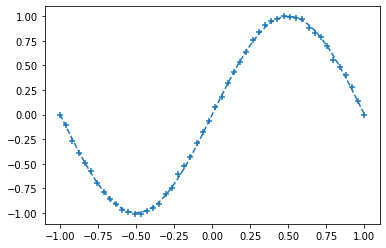

Epoch:700/1001 Error:0.0001359988474593751


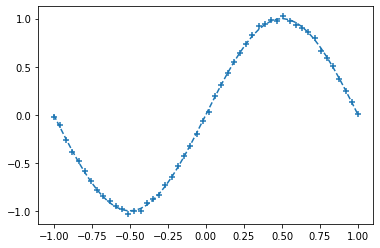

Epoch:750/1001 Error:0.00011710784108324345


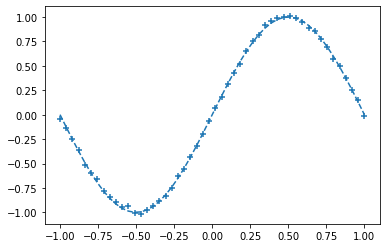

Epoch:800/1001 Error:0.00013581808987081455


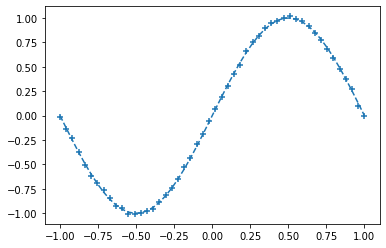

Epoch:850/1001 Error:7.828769675015246e-05


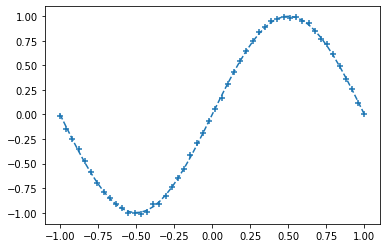

Epoch:900/1001 Error:8.550483532093216e-05


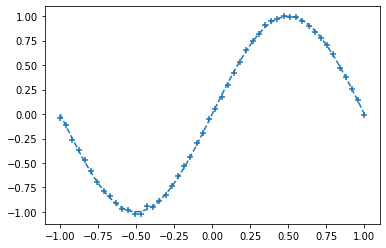

Epoch:950/1001 Error:9.182916740208248e-05


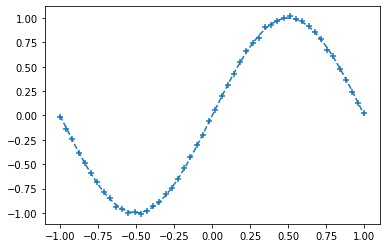

Epoch:1000/1001 Error:6.267185085987145e-05


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -- input data and correct data --
input_data = np.linspace(-np.pi, np.pi)  # original input dataset
correct_data = np.sin(input_data)        # correct dataset
input_data = input_data/np.pi            # to range the realm from -1.0 to 1.0
n_data = len(correct_data)                # number of data

# -- config --
n_in = 1   # the number of neurons at the input layer
n_mid = 12 # the number of neurons at the middle layers
n_out = 1  # the number of neurons at the output layer

wb_width = 0.61  # width of weight and bias
eta = 0.15       # learning coefficient
epoch = 1001
interval = 50    # monitoring interval

# -- supercalss --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)  # weight matrix
        self.b = wb_width * np.random.randn(n)  # bias vector

    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- middlelayer--
class MiddleLayer(BaseLayer):
    def forward(self, x):  # foreward-propagation
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))  # sigmoid function(as activate function)

    def backward(self, grad_y):  # backward-propagation
        delta = grad_y * (1-self.y)*self.y  # differential calculus of sigmoid function

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)

        self.grad_x = np.dot(delta, self.w.T)


# -- output layer --
class OutputLayer(BaseLayer):
    def forward(self, x):  # foreward-propagation
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = u  # identity function

    def backward(self, t):  # backward-propagation
        delta = self.y - t

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)

        self.grad_x = np.dot(delta, self.w.T)


# -- initializing each layer --
middle_layer1 = MiddleLayer(n_in, n_mid)
middle_layer2 = MiddleLayer(n_mid, n_mid)
middle_layer3 = MiddleLayer(n_mid, n_mid)
middle_layer4 = MiddleLayer(n_mid, n_mid)

output_layer = OutputLayer(n_mid, n_out)

# -- start learning --
for i in range(epoch):

    # shffle index
    index_random = np.arange(n_data)
    np.random.shuffle(index_random)

    # plot the results
    total_error = 0
    plot_x = []
    plot_y = []

    for idx in index_random:

        x = input_data[idx]  # original input dataset
        t = correct_data[idx]  # correct dataset

        # foreward-propagation
        middle_layer1.forward(np.array([[x]]))  # transform input data to middle layer1 to matrix
        middle_layer2.forward(middle_layer1.y)
        middle_layer3.forward(middle_layer2.y)
        middle_layer4.forward(middle_layer3.y)
        output_layer.forward(middle_layer4.y)

        # backward-propagation
        output_layer.backward(np.array([[t]]))  # express correct dataset as matrix
        middle_layer4.backward(output_layer.grad_x)
        middle_layer3.backward(middle_layer4.grad_x)
        middle_layer2.backward(middle_layer3.grad_x)
        middle_layer1.backward(middle_layer2.grad_x)

        # update wight and bias
        middle_layer1.update(eta)
        middle_layer2.update(eta)
        middle_layer3.update(eta)
        middle_layer4.update(eta)
        output_layer.update(eta)

        if i%interval == 0:

            y = output_layer.y[0][0]  # get numbers from matrix

            # error estimation
            total_error += 1.0/2.0*np.sum(np.square(y - t))  # mean square error

            # append outputs
            plot_x.append(x)
            plot_y.append(y)

    if i%interval == 0:

        # plot outpus
        plt.plot(input_data, correct_data, linestyle="dashed")
        plt.scatter(plot_x, plot_y, marker="+")
        plt.show()

        # print epoch number and errors
        print("Epoch:" + str(i) + "/" + str(epoch), "Error:" + str(total_error/n_data))